# Stance Detection

In [1]:
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing, feature_engineering, helpers, vis_helper
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools
import utils
import importlib
import re

In [2]:
importlib.reload(preprocessing)
importlib.reload(feature_engineering)
importlib.reload(helpers)
importlib.reload(utils)
preprocess = preprocessing.Preprocessing()
vis = vis_helper.Vis_Helper()

In [3]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [4]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10744, 3), (2683, 3))

In [6]:
ct,ct2 = Counter(stances_val['Stance']),Counter(stances_tr['Stance'])
print(ct, ct2)
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

Counter({'discuss': 1790, 'agree': 731, 'disagree': 162}) Counter({'discuss': 7119, 'agree': 2947, 'disagree': 678})
0.667163622810287


In [7]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [8]:
# [(nltk.pos_tag([x]),preprocess.get_sentiment(x)) for x in preprocess.get_clean_tokens(list(stances_tr.iloc[2,:])[0], False)]

In [9]:
# preprocess.cosine_similarity(glove_dict['reveal'], glove_dict['revealed'])

In [10]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
stances_tr = pd.concat([stances_tr, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [11]:
Counter(stances_tr['Stance'])

Counter({'disagree': 2034, 'agree': 2947, 'discuss': 7119})

In [12]:
def process_word_stance(word, glove_dict):
    #50d word vector
    if word in glove_dict:
        wv = glove_dict[word]
    else:
        wv = np.zeros((50, ))
    #4d sentiment
    sent = preprocess.get_sentiment(word)
    #16d one-hot encoding of part of speech (shortened)
    pos = nltk.pos_tag(word)[1][0]
    pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_short]
    #boolean flag for negating word
    stemmed_word = preprocess.stem_word(word)
    is_neg = (1 if stemmed_word in preprocess.negating_words_stemmed else 0)
    is_refuting = (1 if stemmed_word in preprocess.refuting_words_stemmed else 0)
    embedding = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg, is_refuting], pos_encoding])
    return embedding

def process_text_stance(text, glove_dict, n_words = 20):
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((72,))]*(n_words-len(tokens))
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens]+padding)
    return encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    padding = [np.zeros((72,))]*(1)
    return np.concatenate([process_text_stance(headline, glove_dict), np.array(padding), body_dict[body_id]])

In [13]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [14]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

104


In [15]:
np.array(val_feats).shape

(2683, 61, 72)

In [16]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches)
    return np.swapaxes(batches, 0, 1), np.array(results)

In [17]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [18]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [20]:
# LSTM
class RNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output = None

        
    def forward(self, x):
        #x = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.rnn(x)
        self.output = output
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        #hidden = [batch size, hid dim * num directions]
        fc = self.fc(hidden.squeeze(0))
        fc2 = self.fc2(F.relu(fc))

        return fc2

In [21]:
# Vanilla RNN
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output = None
        
    def forward(self, x):
        output, hidden = self.rnn(x)
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        fc = self.fc(hidden.squeeze(0))
        self.output = output
        return fc

In [22]:
# GRU
class RNN_GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.rnn(x)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        fc = self.fc(hidden.squeeze(0))
        fc2 = self.fc2(F.relu(fc))
        return fc2

In [23]:
# To do: re-implement with LSTMs for each branch
class Siamese_LSTM(nn.Module):
    # hidden dim: dimension of one RNN
    # 2 * hidden dim: concatenated outputs
    def __init__(self,embedding_dim, hidden_dim_head, hidden_dim_bod, 
                 n_layers_head, n_layers_bod, bidirectional, dropout, output_dim):
        super().__init__()
        
        # RNN dimensions [embedding_dim, hidden_dim]
        self.rnn1 = nn.LSTM(72, hidden_dim_head, num_layers=n_layers_head, bidirectional=bidirectional, dropout=dropout)
        self.rnn2 = nn.LSTM(72, hidden_dim_bod, num_layers=n_layers_bod, bidirectional=bidirectional, dropout=dropout)
        # Note: output dim could technically be higher now? cause runnign through a loss function/MLP
       
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear((hidden_dim_head+hidden_dim_bod)*2, (hidden_dim_head+hidden_dim_bod)) #doubled for bidirectional
        self.fc2 = nn.Linear((hidden_dim_head+hidden_dim_bod), output_dim)
        
        self.output1, self.output2 = None, None
        
    def forward(self, x):
        # x originally = [batch size, nubmer of words, embedding dim]
        # swap first two dimensions to match rnn specs
        #print(f'x shape before: ${x.shape}')
        #x = x.permute([1,0,2])
        
        """print(f'x shape: ${x.shape}')"""
        header = x[:20, :, :]
        article = x[20:60, :, :]
        
        """print(f'header shape: ${header.shape}')
        print(f'article shape: ${article.shape}')"""
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        output1, (hidden1, cell1) = self.rnn1(header)
        output2, (hidden2, cell2) = self.rnn2(article)
        
        self.output1, self.output2 = output1, output2
        """print(f'Hidden1 shape: {hidden1.shape}')
        print(f'Hidden2 shape: {hidden2.shape}')"""
        
        # Concats the last forward and backward hidden layers
        # Wouldn't you only technically want to do this if it is in fact bidirectional? 
        hidden1 = torch.cat((hidden1[-2,:,:], hidden1[-1,:,:]), dim=1)
        hidden2 = torch.cat((hidden2[-2,:,:], hidden2[-1,:,:]), dim=1)

        """print(f'Hidden1 shape front/back: {hidden1.shape}')
        print(f'Hidden2 shape front/back: {hidden2.shape}')"""
        
        hidden_merge = torch.cat((hidden1.squeeze(0), hidden2.squeeze(0)),1)
        # TODO: Check if concatenating along dim 1 might be better if first squeeze each hidden
        """print(f'Concatenated shape: {hidden_merge.shape}')"""
     
        hidden = self.dropout(hidden_merge)
        
        # Todo: add more layers beforehand, that's way too many to concatenate down to 3
        fc1 = self.fc1(hidden)
        """print(f'FC shape: {fc1.shape}')"""

        fc1 = F.relu(fc1)

        fc2 = self.fc2(fc1)
        
        return fc2

In [216]:
num_epochs = 5
batch_size = 250

EMBEDDING_DIM = 72
OUTPUT_DIM = 3
DROPOUT = 0.2
N_FILTERS = 100
FILTER_SIZE = 5

HIDDEN_DIM_HEAD = 150
HIDDEN_DIM_BOD = 150

In [217]:
model1 = RNN(EMBEDDING_DIM, 128, OUTPUT_DIM, 1, DROPOUT)
opt1 = torch.optim.Adam(model1.parameters(), lr=2e-4)
m1 = model1, opt1

model2 = RNN_LSTM(EMBEDDING_DIM, 128, OUTPUT_DIM, 1, DROPOUT)
opt2 = torch.optim.Adam(model2.parameters(), lr=2e-4)
m2 = model2, opt2

model3 = Siamese_LSTM(EMBEDDING_DIM, hidden_dim_head=HIDDEN_DIM_HEAD, hidden_dim_bod=HIDDEN_DIM_BOD, 
                dropout=DROPOUT, output_dim=OUTPUT_DIM, n_layers_head=2, n_layers_bod=2, bidirectional=True)
opt3 = torch.optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-5)
m3 = model3, opt3

criterion = nn.CrossEntropyLoss()

C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [218]:
queue = [m3]

In [219]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [220]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)

for x in queue:
    model = x[0]
    optimizer = x[1]
    print("\n")
    start = time.time()
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, batches_train, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, batches_val, criterion)

        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
        
    end = time.time()
    print(int(end-start))



| Epoch: 01 | Train Loss: 1.002 | Train Acc: 57.56% | Val. Loss: 0.811 | Val. Acc: 67.24% |
| Epoch: 02 | Train Loss: 0.910 | Train Acc: 58.88% | Val. Loss: 0.744 | Val. Acc: 67.24% |
| Epoch: 03 | Train Loss: 0.857 | Train Acc: 60.62% | Val. Loss: 0.712 | Val. Acc: 72.48% |
| Epoch: 04 | Train Loss: 0.813 | Train Acc: 62.68% | Val. Loss: 0.701 | Val. Acc: 72.00% |
| Epoch: 05 | Train Loss: 0.761 | Train Acc: 65.74% | Val. Loss: 0.668 | Val. Acc: 70.52% |
324


In [224]:
with torch.no_grad():
    batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],0,250)
    inputs = Variable(torch.FloatTensor(batch_x))
    labels = Variable(torch.LongTensor(batch_y))
    predictions = model(inputs)
    _, predicted = torch.max(predictions.data, 0)
#output = model.output.permute([1,0,2]).squeeze(0)
output1, output2 = model.output1, model.output2

In [225]:
def get_values(text, tokens, cell):
    j = 0 # index in tokens for duplicate token values
    num_word = 0
    body = [{} for i in range(len(text))]
        
    for i in range(len(text)):
        test = preprocess.clean(text[i])
        test = preprocess.get_tokenized_lemmas(test)
        test = preprocess.remove_stopwords(test, True)
        if(len(test)==0): 
            body[i] = {text[i]:str(0)}
            #print(text_body[i], 0)
        else:
            #token_index = np.where(tokens[j:]==test[0])
            index = list(tokens[j:]).index(test[0])
            body[i] = {text[i]:str(cell[j])}
            j+=1
    return body

In [226]:
body = stances_val.iloc[0]["Body ID"]
text_body = preprocess.get_body(body,train_bodies)
text_headline = stances_val.iloc[0]["Headline"]

In [227]:
act_cells = [{} for i in range(output1.shape[2])]
for i in range(output1.shape[2]):
    cell_headline = np.array(np.swapaxes(output1[:,0,:], 0, 1)[i])
    tokens_headline = preprocess.get_clean_tokens(text_headline, False)[:20]
    list_headline = text_headline.split(" ")
    v_headline = get_values(list_headline, tokens_headline, cell_headline)
    
    cell_body = np.array(np.swapaxes(output2[:,0,:], 0, 1)[i])
    tokens_body = preprocess.get_clean_tokens(text_body, False)[:40]
    list_body = text_body.split(" ")[:40]
    v_body = get_values(list_body, tokens_body, cell_body)
        
    act_cells[i] = {"headline":v_headline, "body":v_body, "cell":str(i)}

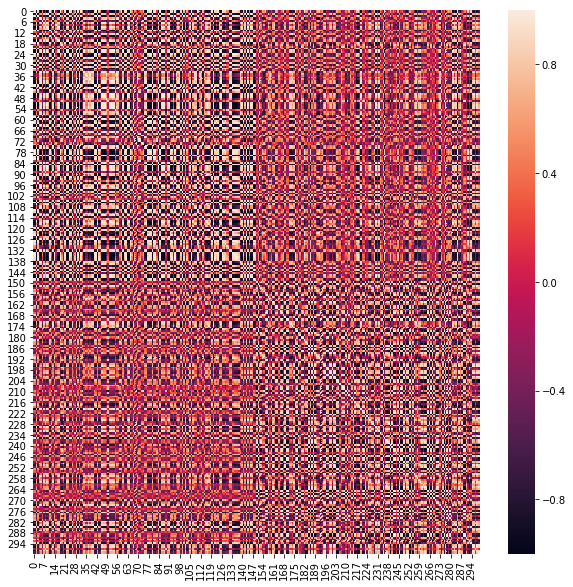

In [229]:
# Observation: for Siamese networks the "grid" pic goes away with more trainign. Maybe try increasing more? 
output1_cov = np.corrcoef(np.array(output1[:,0,:]), rowvar=False)

plt.figure(figsize=(10,10))
ax = sns.heatmap(output1_cov.T)
plt.show()

In [232]:
# Siamese network: look at the similarity in headline/body output vectors for
print(output1[:,0,:].shape, output2[:,0,:].shape)

torch.Size([20, 300]) torch.Size([40, 300])


In [254]:
important1 = vis.get_important_cells(np.array(output1[:,0,:]), 300)
important2 = vis.get_important_cells(np.array(output2[:,0,:]), 300)
print(important1["top5_mag"], important2["top5_mag"])

['210', '6', '274', '233', '282'] ['35', '106', '4', '92', '29']


In [264]:
a = np.array(output1[:,0,210])
b = np.array(output2[:,0,210])
print(output1.shape, output2.shape)

torch.Size([20, 250, 300]) torch.Size([40, 250, 300])


In [283]:
norms = []
# Find all the words with similar "representations", being the activations for every cell at that time step
for i in range((output1.shape[0])): 
    for j in range((output2.shape[0])):
        dot = np.dot(np.array(output1[i, 0, :]),np.array(output2[j, 0, :]))
        norm = np.linalg.norm(np.array(output1[i, 0, :]))*np.linalg.norm(np.array(output2[j, 0, :]))
        norms.append(dot/norm)
        #print(dot/norm)
norms = np.array(norms)
scipy.stats.describe(norms)

DescribeResult(nobs=800, minmax=(-0.100137524, 0.09534669), mean=0.029272635, variance=0.0016077603, skewness=-1.3708176612854004, kurtosis=0.6580719611506098)

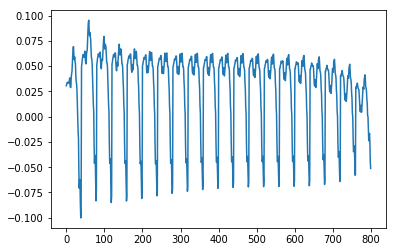

In [284]:
plt.plot(norms)

In [ ]:
# Format for storing the cells of note for a specific sentence
cells_json = {
    "activations":act_cells,
    "top5_mag":[str(i) for i in output3_norm[:5]],
    "bot5_mag":[str(i) for i in output3_norm[-5:]],
    "top5_var":[str(i) for i in output3_var[:5]],
    "bot5_var":[str(i) for i in output3_var[-5:]],
    "top5_corr":[[str(i[0]), str(i[1])] for i in cov_pairs]
}
"""with open('Vis/activations_LSTM_goodCells.json', 'w') as outfile:
    json.dump(cells_json, outfile)"""